## Partie : Prédiction basée sur les clusters

Ce notebook présente l'apprentissage d'un classifieur de fruits multiclasse avec un classifieur naif bayesin s'appuyant sur la loi de bernoulli.
Ce qui est important avec ce choix de modélisation, c'est qu'il faut que nos données soit binaire, c'est à dire 0/1, car c'est le critère de l'expérience de Bernouilli. Donc, dans cette partie nous allons étudier les performance d'un pre processing sur la découpage d'image en patch. Ces derniers seront ensuite dans un Kmeans afin de calculer les clusters. Enfin les images seront traduites par un vecteur de taille égale au nombre de clusters et qui contiendra 1 si un patch appartient à ce cluster.

## Importation des libs

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle
import random

## Importation des données

Nous avons extrait ces données depuis un dataset disponible sur kaggle à l'adresse suivante : https://www.kaggle.com/datasets/moltean/fruits

In [2]:
fruits = ["Banane","Mais","Fraise","Framboise","Clementine","Poire",
          "Nectarine","Orange","Lychee","Kiwi","Mirtille","Cerise",
          "Abricot","Citron","Melon","Tangelo","Plum","Peche","Kaki","Mangue"]

In [36]:
format_fichier = [".jpg"]

def lire_images(cheminRacine, array, y, index):   
    print(f"chargement {fruits[index]}")
    for lists in tqdm(os.listdir(cheminRacine)): 
        chemin = os.path.join(cheminRacine, lists) 
        filename, extension = os.path.splitext(chemin) 
        if extension in format_fichier:   
            array.append(mpimg.imread(chemin))
            y.append(index)
        if os.path.isdir(chemin): 
            lire_images(chemin, array, y, index)
images = []
classes = []

#remplissage de la liste d'images + classes
lire_images("../Training/Banana", images, classes, 0)
lire_images("../Training/Corn", images, classes, 1)
lire_images("../Training/Strawberry", images, classes, 2)
lire_images("../Training/Raspberry", images, classes, 3)
lire_images("../Training/Clementine", images, classes, 4)
lire_images("../Training/Pear Williams", images, classes, 5)
lire_images("../Training/Nectarine", images, classes, 6)
lire_images("../Training/Orange", images, classes, 7)
lire_images("../Training/Lychee", images, classes, 8)
lire_images("../Training/Kiwi", images, classes, 9)
lire_images("../Training/Blueberry", images, classes, 10)
lire_images("../Training/Cherry 1", images, classes, 11)
lire_images("../Training/Apricot", images, classes, 12)
lire_images("../Training/Lemon", images, classes, 13)
lire_images("../Training/Watermelon", images, classes, 14)
lire_images("../Training/Tangelo", images, classes, 15)
lire_images("../Training/Plum", images, classes, 16)
lire_images("../Training/Peach", images, classes, 17)
lire_images("../Training/Kaki", images, classes, 18)
lire_images("../Training/Mango", images, classes, 19)




K = len(fruits)

images,classes = shuffle(images, classes, random_state=10) 

chargement Banane


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2492.97it/s]


chargement Mais


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 2691.83it/s]


chargement Fraise


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2186.34it/s]


chargement Framboise


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2640.35it/s]


chargement Clementine


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2703.98it/s]


chargement Poire


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2685.42it/s]


chargement Nectarine


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2354.46it/s]


chargement Orange


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:00<00:00, 2563.63it/s]


chargement Lychee


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2718.73it/s]


chargement Kiwi


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 466/466 [00:00<00:00, 2610.37it/s]


chargement Mirtille


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 2471.72it/s]


chargement Cerise


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2577.97it/s]


chargement Abricot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2566.93it/s]


chargement Citron


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2532.80it/s]


chargement Melon


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 2671.73it/s]


chargement Tangelo


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2250.67it/s]


chargement Plum


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 2132.82it/s]


chargement Peche


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 1618.88it/s]


chargement Kaki


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2098.84it/s]


chargement Mangue


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 1957.41it/s]


In [37]:
images_a = np.asarray(images, dtype=int)
classes_a = np.asarray(classes, dtype=int)

print(images_a.shape)
print(classes_a.shape)
print(f"Nous avons au total {len(images)} images dans notre dataset en 50x50 avec 3 couleurs") 

(9651, 50, 50, 3)
(9651,)
Nous avons au total 9651 images dans notre dataset en 50x50 avec 3 couleurs


Voici une representation d'images de notre dataset :


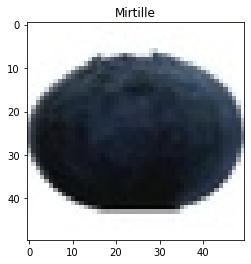

In [38]:
print("Voici une representation d'images de notre dataset :")
index_demo = 1
img_demo = images[index_demo]
plt.figure()
plt.imshow(img_demo)
plt.title(fruits[classes[index_demo]])
plt.show()

## Fonctions de préparation des données

Voici quelques fonctions utiles qui vont nous permettre de travailler sur nos données pour les découper en patch et de les transformer en nuance de gris.

In [39]:
def transformer_en_gris(img_orig):
    im = np.zeros((img_orig.shape[0],img_orig.shape[1])) # On fait une copie de l'original
    for i in range(img_orig.shape[0]):
        for j in range(img_orig.shape[1]):
            r, v, b = img_orig[i, j]
            moyenne = np.mean(img_orig[i, j])
            im[i, j] = int(moyenne)
    return im

def decouper_image(image, taille) :
    return [image[x:x+taille,y:y+taille] for x in range(0,image.shape[0],taille) for y in range(0,image.shape[1],taille)]

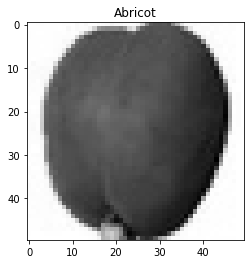

nombre de patch : 4
dimension d'un patch de l'image (25, 25, 3)


<Figure size 432x288 with 0 Axes>

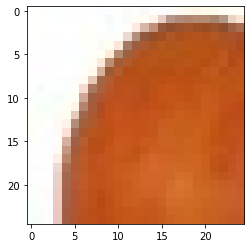

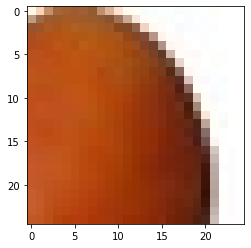

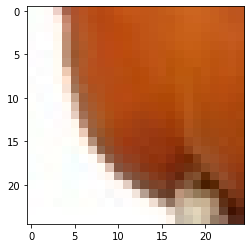

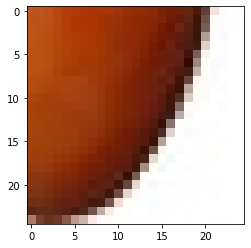

In [40]:
index_test = 0
image_test = images[index_test]
image_gris = transformer_en_gris(image_test)

plt.figure()
plt.imshow(image_gris,  cmap='gray')
plt.title(fruits[classes[index_test]])
plt.show()

nbPatch = 4
taillePatch = int((np.shape(images)[1]+np.shape(images)[2])/nbPatch)
image_decoupe = decouper_image(image_test, taillePatch)
print(f"nombre de patch : {len(image_decoupe)}")
print(f"dimension d'un patch de l'image {image_decoupe[0].shape}")
plt.figure()
for i in range(nbPatch) :
    plt.figure()
    plt.imshow(image_decoupe[i])
    plt.show()

## Fonctions de preprocessing

Fonction qui prends en entrée un dataset d'image et qui retourne les images découpées en patch

In [18]:
def preprocessing(images,nbPatch):
    taillePatch = int((np.shape(images)[1]+np.shape(images)[2])/nbPatch)
    X = np.zeros((np.shape(images)[0]*nbPatch,taillePatch,taillePatch))
    insertion = 0
    for i in range(np.shape(images)[0]):
        image_grise = transformer_en_gris(images[i]) # Recuperation de l'image i
        image_decoupe_list = decouper_image(image_grise,taillePatch) # image découpé
        for j in range(nbPatch):
            X[insertion] = image_decoupe_list[j]
            insertion += 1
    return X

In [19]:
X_preprocessing = preprocessing(images,4)

In [22]:
print(f"Patch disponible {X_preprocessing.shape}")

Patch disponible (38604, 25, 25)


## Algorithme des K-Moyennes

In [23]:
def dist(x1, x2) :
    return np.abs(x1-x2).sum()

class Kmoyennes:

    def __init__(self,K, taillePatch, IterationMax): ## instanciation d'un objet du type de la classe.
        self.K = K
        self.taillePatch = taillePatch
        self.N = 0
        self.D = 0
        self.IterationMax = IterationMax
        self.affectations = np.zeros((self.N))
        self.representants = np.zeros((self.K, self.taillePatch, self.taillePatch)) #les representants sont des patches
    
    def fit(self,X):
        self.N = X.shape[0]
        self.D = X.shape[1]
        representants_initiaux = []
        for i in range(self.K) :
            representants_initiaux.append(np.random.randint(255, size=(self.taillePatch, self.taillePatch)))
        representants = np.array(representants_initiaux)    
        
        for iterations in range(self.IterationMax):
            affectations = self.maj_affectations(X, representants)
            representants = self.maj_representants(X, affectations)
            
        self.representants = representants
        self.affectations = affectations
        return self.representants
    
    #retourne l'image moyenne (moyenne pixel a pixel de chaque patch du groupe X)
    def barycentre(self, X) :
        if X.shape[0] == 0 :
            return None
        return X.mean(axis=0)
    
    def maj_affectations(self, X, r):
        N = X.shape[0]
        K = r.shape[0]
        a = np.zeros((N, K))
        for n in range(N):
            distances = np.zeros(K)
            for k in range(K):
                distances[k] = dist(X[n], r[k])
            a[n, np.argmin(distances, axis=0)] = 1
        return a

    def maj_representants(self, X, a):
        K = self.K
        r = np.zeros((K,self.taillePatch, self.taillePatch))
        for k in range(K):
            masque = a[:,k] == 1
            barycentre = self.barycentre(X[masque])
            if barycentre is not None :
                r[k] = barycentre
        return r

In [24]:
#retourne la matrice des appartenances des patches aux features pour chaque image
def matrice_resultat_kmoyennes(affectationsKmeans, nbPatches):
    resultats = np.zeros((int(affectationsKmeans.shape[0]/nbPatches),affectationsKmeans.shape[1]))
    for image in range(resultats.shape[0]):
        patchesImage = affectationsKmeans[(nbPatches*image):(nbPatches*image+nbPatches)]
        somme = np.sum(patchesImage, axis=0)
        somme[somme >= 1] = 1
        resultats[image] = somme
    return resultats

## Modèle du bayesien naïf : representation sous forme de loi de Bernoulli

Pour contruire notre fonction de classification, on va représenter nos données sous forme binaire afin de pouvoir effectuer une expérience de Bernoulli dessus. C'est à dire que chaque dimension d'un exemple doit valoir soit 0 soit 1 afin qu'on puisse calculer ce type de probabilité :
$ P(X_d = x_d | \theta , y) = p_i^{x_d}*(1 - p_d)^{(1 - x_d)}$ ou $d$ représente une dimension, $p_d \in[0,1] $ la probabilité que cette dimension prenne la valeur $1$ , $y \in \{classe\}$ la classe, et $x_d \in \{0,1\}$ la valeur possible.

Pour construire notre classifieur, nous cherchons à choisir la probabilité maximum d'une classe par rapport a l'image et a des paramètres que l'on va apprendre. on écrit cela ainsi :
<p style="text-align: center;">
    $ y_{pred} = argmax_y P(y | x_i , \theta)$
</p>
Ou $i$ représente l'image $i$.

Notre fonction de prediction s'écrira donc : 
<p style="text-align: center;">
    $f_{\theta}(x_i) = argmax_y P(y | x_i , \theta)$
</p>
Pour calculer la quantité $P(y | x_i , \theta)$, nous allons passer par la loi de Bayes ($P(A,B) = P(A|B)P(B) = P(B|A)P(A) <=> P(A|B) = P(B|A)P(A)/P(B)$)

Ce qui nous donne : $P(y | x_i , \theta) = \frac{P(x_i | y , \theta) P(y)}{P(x_i)}$. De plus, on remarque que $P(x_i)$ est constant pour chaque classe, nous pouvons donc l'enlever de l'équation car le résultat sera proportionnel. \
On obtient : 
<p style="text-align: center;">
    $P(y | x_i , \theta) = P(x_i | y , \theta) P(y) $
</p>
La prior $P(y)$ est la probabilté qu'un exemple soit de la classe $y$ donc nous pouvons calculer cette quantité trivialement en comptant le nombre 
d'exemple de la classe puis en divisant par le nombre total d'exemples tel que.
<p style="text-align: center;">
    $P(y_j) = \frac{1}{N}\sum_{i}^{N} classe(x_i,y_j)$
</p>
Ou $N$ représente le nombre d'exemple du dataset et $classe(x_i)$ est une fonction indicatrice si $x_i$ est bien de la classe $y_i$

La vraissemblance des données par rapport aux classes et aux paramètres ce calcul de la manière suivante en faisant une hypothèse d'indépendance entre les dimensions sinon le calcul n'aura pas été faisable: 
<p style="text-align: center;">
    $ P(x_i | y_k , \theta) = \prod_{d}^{D} P(x_{i,d} | \theta)$
</p>
<p style="text-align: center;">
    $ = \prod_{d}^{D} p_{k,d}^{x_{i,d}}*(1 - p_{k,d})^{(1 - x_{i,d})}$
</p>
Nous voyons d'après cette équations que nous avons à trouver les valeurs de nb clusters paramètres ($p_{k,d} \in \theta$).
20 : nombre de classe.

En résumant les équations ci-dessus la fonction finale de prédiction s'écrit : 
<p style="text-align: center;">
    $f_{\theta}(x_i) = argmax_y  \prod_{d}^{D} p_{k,d}^{x_{i,d}}*(1 - p_{k,d})^{(1 - x_{i,d})} * \frac{1}{N}\sum_{i}^{N} classe(x_i,y_j) $
</p>

Nous avons à présent besoin de trouver les paramètres $p_{k,d}$ nécessaire à notre fonction de prédiction. Pour cela nous allons les estimés par la méthode du maximum de vraisemblance. Comme nous l'avons dit plutot la vraisemblance se définit par : $ L(x_i,\theta,y_k) = P(x_i | y_k , \theta) = \prod_{d}^{D} P(x_{i,d} | \theta)$ pour un exemple de la classe $k$. La vraisemblance d'un ensemble d'exemple pour la classe $k$ s'exprime par ($|y_k|$ représente le nombre d'exemple de la classe $k$) : 
<p style="text-align: center;">
$L(x,\theta,y_k) = \prod_{i}^{|y_k|} \prod_{d}^{D} P(x_{i,d} | \theta) $
</p>
<p style="text-align: center;">
$ = \prod_{i}^{|y|} \prod_{d}^{D} p_{k,d}^{x_{i,d}}*(1 - p_{k,d})^{(1 - x_{i,d})} $
</p>

Pour trouver les $p_{k,d}^{*}$, nous allons devoir dérivée cette expression afin de trouver l'optimum de cette fonction et d'isoler les $p_{k,d}$. Pour cela, nous allons d'abord calculer la log-vraissemblance pour faciliter les calculs ensuite (log(.) étant une fonction strictement croissante, cela ne fausse donc pas les calculs).
<p style="text-align: center;">
$ log L(x,\theta,y_k) = log \prod_{i}^{|y|} \prod_{d}^{D} p_{k,d}^{x_{i,d}}*(1 - p_{k,d})^{(1 - x_{i,d})} $
</p>
<p style="text-align: center;">
$ = \sum_{i}^{|y|} \sum_{d}^{D} log[ p_{k,d}^{x_{i,d}}*(1 - p_{k,d})^{(1 - x_{i,d})}] $ (log(a * b) = log(a) + log(b))
</p>
<p style="text-align: center;">
$ = \sum_{i}^{|y|} \sum_{d}^{D} x_{i,d}*log(p_{k,d}) + (1 - x_{i,d})*log(1 - p_{k,d}) $
</p>

Nous allons maintenant annuler la dérivé de cette expression par rapport aux $p_{k,d}$:

<p style="text-align: center;">
$ (log L(x,\theta,y_k))'(p_{k,d}) = \sum_{i}^{|y|} \frac{x_{i,d}}{p_{k,d}}-\frac{1 - x_{i,d}}{1 - p_{k,d}}  $ (d étant en indice on peut enlever la somme et dérivé de somme = somme des dérivées)
</p>

Isolons les $p_{k,d}$ en posant l'équations = 0.
<p style="text-align: center;">
$ (log L(x,\theta,y_k))'(p_{k,d}) = 0 $
</p>
<p style="text-align: center;">
$ \sum_{i}^{|y|} \frac{x_{i,d}}{p_{k,d}}-\frac{1 - x_{i,d}}{1 - p_{k,d}} = 0 $
</p>
<p style="text-align: center;">
$ \sum_{i}^{|y|} \frac{x_{i,d}(1 - p_{k,d}) - (1 - x_{i,d})*p_{k,d}}{p_{k,d}(1 - x_{i,d})} = 0 $
</p>
<p style="text-align: center;">
$ \sum_{i}^{|y|} x_{i,d}(1 - p_{k,d}) - (1 - x_{i,d})*p_{k,d} = 0 $
</p>
<p style="text-align: center;">
$ \sum_{i}^{|y|} x_{i,d} -x_{i,d}p_{k,d} -p_{k,d} + x_{i,d}p_{k,d}  = 0 $
</p>
<p style="text-align: center;">
$ \sum_{i}^{|y|} x_{i,d} -p_{k,d} = 0 $
</p>
<p style="text-align: center;">
$  |y| * p_{k,d}  = \sum_{i}^{|y|} x_{i,d} $
</p>
<p style="text-align: center;">
$   p_{k,d,*}  = \frac{1}{|y|}\sum_{i}^{|y|} x_{i,d} $
</p>

Après avoir calculer tous les $p_{k,d,*}$, la fonction de prédiction est :
<p style="text-align: center;">
    $f_{\theta}(x_i) = argmax_y  \prod_{d}^{D} p_{k,d,*}^{x_{i,d}}*(1 - p_{k,d,*})^{(1 - x_{i,d})} * \frac{1}{N}\sum_{i}^{N} classe(x_i,y_j) $
</p>


In [41]:
def BayesienNaif_fit(X,y):
    N = X.shape[0]
    D = X.shape[1]
    
    pkd = np.zeros((K,D))
    Pk = np.zeros((K,))
    
    for k in range(K):
        mask = (y == k)
        Pk[k] = np.sum(mask) / N
        Xk = X[mask]
        
        for d in range(D):
            count = 0
            for n in range(Xk.shape[0]):
                count += Xk[n , d]
            
            pkd[k , d] = count / Xk.shape[0]
    
    return pkd, Pk

def BayesienNaif_predict(X, pkd, Pk):
    epsilon = 1e-8
    N = X.shape[0]
    D = X.shape[1]
    
    y_pred = np.zeros(N)
    
    for n in range(N):
        x = X[n]
        score = np.zeros(K)
        for k in range(K):
            score[k] = (
                np.log(Pk[k])
                +
                np.sum(
                x * np.log(pkd[k] + epsilon)
                    +
                (1 - x) * np.log(1 - pkd[k] + epsilon)
                )
            )
        k = np.argmax(score)
        y_pred[n] = k
    return y_pred

## Fonctions de Cross-Validation sur le nombre de cluster

In [42]:
def appartenances_images_cibles(imagesValidation, nbPatches, representants) :
    patchesImages = preprocessing(imagesValidation,nbPatches)
    representantsCible = np.zeros((np.shape(imagesValidation)[0]*4,representants.shape[0]))
    for n in range(patchesImages.shape[0]) :
        distances = np.zeros(representants.shape[0])
        for k in range(representants.shape[0]) :
            distances[k] = dist(patchesImages[n], representants[k])
        representantsCible[n][np.argmin(distances)] = 1
    return matrice_resultat_kmoyennes(representantsCible, nbPatches)

In [44]:
#propTest entre 0 et 1
def separer_train_test(images, classes, propTest) :
    N = np.shape(images)[0]
    Ntest = int(propTest * N)
    return images[:Ntest], classes[:Ntest], images[Ntest :], classes[Ntest :]

#indexVal entre 0 et 4
def decouper_folds(imagesSansTest,classesSansTest, indexVal) :
    indexReel = int((np.shape(imagesSansTest)[0]/5)*indexVal)
    largeurIntervalle = int(np.shape(imagesSansTest)[0]/5)
    
    images_train =  imagesSansTest[: indexReel] + imagesSansTest[(indexReel+largeurIntervalle) : ]
    classes_train = classesSansTest[: indexReel] + classesSansTest[(indexReel+largeurIntervalle) : ]
    images_validation = imagesSansTest[indexReel:(indexReel+largeurIntervalle)]
    classes_validation = classesSansTest[indexReel:(indexReel+largeurIntervalle)]
        
    return images_train, classes_train, images_validation, classes_validation

print(np.shape(images))

images_sans_test, classes_sans_test, images_test, classes_test =  separer_train_test(images, classes, 0.80)

print(np.shape(images_sans_test))
print(np.shape(classes_sans_test))
print(np.shape(images_test))
print(np.shape(classes_test))

images_train, classes_train, images_validation, classes_validation = decouper_folds(images_sans_test, classes_sans_test, 4)

print(np.shape(images_train))
print(np.shape(classes_train))
print(np.shape(images_validation))
print(np.shape(classes_validation))                         

(9651, 50, 50, 3)
(7720, 50, 50, 3)
(7720,)
(1931, 50, 50, 3)
(1931,)
(6176, 50, 50, 3)
(6176,)
(1544, 50, 50, 3)
(1544,)


  0%|                                                                                                                                                                                                                | 0/14 [00:00<?, ?it/s]

accuracy : 0.6972612879348631 nb cluster : 60 it : 0
accuracy : 0.765358993338268 nb cluster : 60 it : 1
accuracy : 0.6572908956328646 nb cluster : 60 it : 2
accuracy : 0.7113249444855663 nb cluster : 60 it : 3


  7%|██████████████                                                                                                                                                                                      | 1/14 [21:23<4:38:11, 1283.98s/it]

accuracy : 0.7276091783863805 nb cluster : 60 it : 4
fin itération
accuracy : 0.7557364914877869 nb cluster : 65 it : 0
accuracy : 0.7594374537379719 nb cluster : 65 it : 1
accuracy : 0.7572168763878608 nb cluster : 65 it : 2
accuracy : 0.770540340488527 nb cluster : 65 it : 3


 14%|████████████████████████████                                                                                                                                                                        | 2/14 [43:08<4:19:13, 1296.14s/it]

accuracy : 0.7505551443375278 nb cluster : 65 it : 4
fin itération
accuracy : 0.7468541820873427 nb cluster : 70 it : 0
accuracy : 0.8312361213915618 nb cluster : 70 it : 1
accuracy : 0.7017024426350851 nb cluster : 70 it : 2
accuracy : 0.767579570688379 nb cluster : 70 it : 3


 21%|█████████████████████████████████████████▌                                                                                                                                                        | 3/14 [1:05:13<4:00:00, 1309.16s/it]

accuracy : 0.7934863064396743 nb cluster : 70 it : 4
fin itération
accuracy : 0.8201332346410066 nb cluster : 75 it : 0
accuracy : 0.7527757216876387 nb cluster : 75 it : 1
accuracy : 0.7660991857883049 nb cluster : 75 it : 2
accuracy : 0.7616580310880829 nb cluster : 75 it : 3


 29%|███████████████████████████████████████████████████████▍                                                                                                                                          | 4/14 [1:27:44<3:40:56, 1325.70s/it]

accuracy : 0.8031088082901554 nb cluster : 75 it : 4
fin itération
accuracy : 0.7772020725388601 nb cluster : 80 it : 0
accuracy : 0.7875647668393783 nb cluster : 80 it : 1
accuracy : 0.7638786084381939 nb cluster : 80 it : 2
accuracy : 0.7779422649888971 nb cluster : 80 it : 3


 36%|█████████████████████████████████████████████████████████████████████▎                                                                                                                            | 5/14 [1:50:52<3:22:12, 1348.09s/it]

accuracy : 0.7335307179866766 nb cluster : 80 it : 4
fin itération
accuracy : 0.7927461139896373 nb cluster : 85 it : 0
accuracy : 0.7860843819393042 nb cluster : 85 it : 1
accuracy : 0.8045891931902295 nb cluster : 85 it : 2
accuracy : 0.7860843819393042 nb cluster : 85 it : 3


 43%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 6/14 [2:14:25<3:02:41, 1370.20s/it]

accuracy : 0.8290155440414507 nb cluster : 85 it : 4
fin itération
accuracy : 0.8238341968911918 nb cluster : 90 it : 0
accuracy : 0.7801628423390081 nb cluster : 90 it : 1
accuracy : 0.8023686158401184 nb cluster : 90 it : 2
accuracy : 0.8282753515914137 nb cluster : 90 it : 3


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 7/14 [2:38:29<2:42:40, 1394.36s/it]

accuracy : 0.7801628423390081 nb cluster : 90 it : 4
fin itération
accuracy : 0.7816432272390822 nb cluster : 95 it : 0
accuracy : 0.8201332346410066 nb cluster : 95 it : 1
accuracy : 0.8008882309400445 nb cluster : 95 it : 2
accuracy : 0.7986676535899334 nb cluster : 95 it : 3


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 8/14 [3:02:58<2:21:49, 1418.22s/it]

accuracy : 0.8075499629903775 nb cluster : 95 it : 4
fin itération
accuracy : 0.7957068837897854 nb cluster : 100 it : 0
accuracy : 0.8549222797927462 nb cluster : 100 it : 1
accuracy : 0.8297557364914878 nb cluster : 100 it : 2
accuracy : 0.8201332346410066 nb cluster : 100 it : 3


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 9/14 [3:27:53<2:00:10, 1442.14s/it]

accuracy : 0.8230940044411547 nb cluster : 100 it : 4
fin itération
accuracy : 0.7638786084381939 nb cluster : 105 it : 0
accuracy : 0.8297557364914878 nb cluster : 105 it : 1
accuracy : 0.8149518874907475 nb cluster : 105 it : 2
accuracy : 0.7816432272390822 nb cluster : 105 it : 3


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 10/14 [3:53:16<1:37:48, 1467.23s/it]

accuracy : 0.7964470762398224 nb cluster : 105 it : 4
fin itération
accuracy : 0.8008882309400445 nb cluster : 110 it : 0
accuracy : 0.8423390081421169 nb cluster : 110 it : 1
accuracy : 0.8556624722427831 nb cluster : 110 it : 2
accuracy : 0.7897853441894893 nb cluster : 110 it : 3


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 11/14 [4:19:13<1:14:43, 1494.53s/it]

accuracy : 0.8297557364914878 nb cluster : 110 it : 4
fin itération
accuracy : 0.8282753515914137 nb cluster : 115 it : 0
accuracy : 0.847520355292376 nb cluster : 115 it : 1
accuracy : 0.7809030347890451 nb cluster : 115 it : 2
accuracy : 0.8401184307920059 nb cluster : 115 it : 3


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 12/14 [4:45:42<50:46, 1523.21s/it]

accuracy : 0.8023686158401184 nb cluster : 115 it : 4
fin itération
accuracy : 0.7994078460399704 nb cluster : 120 it : 0
accuracy : 0.8060695780903034 nb cluster : 120 it : 1
accuracy : 0.8267949666913398 nb cluster : 120 it : 2
accuracy : 0.769059955588453 nb cluster : 120 it : 3


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 13/14 [5:12:34<25:50, 1550.21s/it]

accuracy : 0.7801628423390081 nb cluster : 120 it : 4
fin itération
accuracy : 0.8134715025906736 nb cluster : 125 it : 0
accuracy : 0.8423390081421169 nb cluster : 125 it : 1
accuracy : 0.8771280532938565 nb cluster : 125 it : 2
accuracy : 0.8179126572908957 nb cluster : 125 it : 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [5:40:04<00:00, 1457.46s/it]

accuracy : 0.8223538119911177 nb cluster : 125 it : 4
fin itération


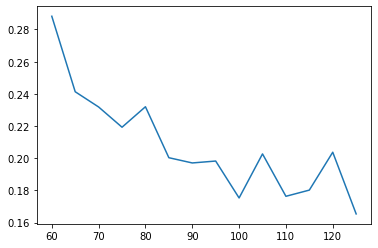

In [46]:
#cross-validation

nbPatches = 4
nbClustersToTest = [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125]
erreurs = []

images_sans_test, classes_sans_test, images_test, classes_test =  separer_train_test(images, classes, 0.70)

for nb in tqdm(nbClustersToTest) :
    accuracyCum = 0
    for i in range(5) :
        images_train, classes_train, images_validation, classes_validation = decouper_folds(images_sans_test, classes_sans_test, i)
        patches_train = preprocessing(images_train, nbPatches) #pas optimal, en plus de prendre bcp de temps
        Km = Kmoyennes(K=nb, taillePatch=25, IterationMax=10)
        Km.fit(X=np.array(patches_train)) 
        representants = Km.representants
        affectations = Km.affectations
        X_train = matrice_resultat_kmoyennes(affectations, nbPatches)
        pkd , Pk = BayesienNaif_fit(X_train, np.array(classes_train))
        X_validation = appartenances_images_cibles(images_validation, nbPatches, representants)
        ypred = BayesienNaif_predict(np.array(X_validation), pkd,Pk)
        accuracy = np.sum(classes_validation == ypred) / np.shape(images_validation)[0]
        print(f'accuracy : {accuracy} nb cluster : {nb} it : {i}')
        accuracyCum += accuracy
    accuracyCum /= 5
    erreurs.append(1-accuracyCum)
    print('fin itération')

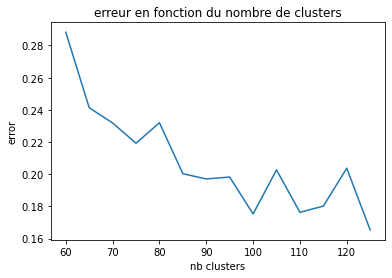

In [59]:
plt.figure()
plt.plot(nbClustersToTest, erreurs)
plt.xlabel("nb clusters")
plt.ylabel("error")
plt.title("erreur en fonction du nombre de clusters")
plt.show()

## Test et résultat du modèle

In [49]:
# Test du modele
images_sans_test, classes_sans_test, images_test, classes_test =  separer_train_test(images, classes, 0.70)

nbPatches = 4
patches_train = preprocessing(images_sans_test, nbPatches)
Km = Kmoyennes(K=120, taillePatch=25, IterationMax=20)
Km.fit(X=np.array(patches_train)) 
representants = Km.representants
affectations = Km.affectations

X_train = matrice_resultat_kmoyennes(affectations, nbPatches)
X_test = appartenances_images_cibles(images_test, nbPatches, representants)

In [50]:
pkd , Pk = BayesienNaif_fit(X_train, np.array(classes_sans_test))

In [55]:
ypred_test = BayesienNaif_predict(np.array(X_test), pkd,Pk)
ypred_train = BayesienNaif_predict(np.array(X_train), pkd,Pk)

accuracy_test = np.sum(classes_test == ypred_test) / np.shape(images_test)[0]
accuracy_train = np.sum(classes_sans_test == ypred_train) / np.shape(images_sans_test)[0]

In [56]:

print(f"accuracy en train : {accuracy_train*100}%")
print(f"accuracy en test : {accuracy_test*100}%")


accuracy en train : 84.57438934122872%
accuracy en test : 84.80662983425414%


In [57]:
index_test = 1000
print(f'valeur de l\'image : {classes_test[index_test]} valeur predite : {ypred[index_test]}')

valeur de l'image : 11 valeur predite : 11.0


## Conclusion

Ce choix de pre processing à été payant car c'est l'option qui nous retourne de meilleurs performance en entrainement et en test. Le choix de l'hyper paramètre du nombre de cluster à été choisi par cross validation.